In [1]:
import numpy as np
import constants_and_functions as cf
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
import os
from scipy.ndimage import convolve
import time

In [2]:
this_path = os.getcwd()
base_path = this_path.split('scripts')[0]
print(base_path)

/het/p4/mjw283/eventgen_wd/Secondary_radiation/


In [3]:
#model parameters
#magnetic field
B0 = 9
B1 = 11
RB0 = 40000
RB1 = 1500
zB0 = 668
zB1 = 0.068

#radiation field
rho_star0 = 15.2
z_star0 = 3850
R_star0 = 3120

#Hydrogen
nHI0 = 11.1
RHI = 3130
hz0 = 90
Rh = 9800
nH20 = 249
RH2 = 1800
zH2 = 50

#Helium ratio
rat = 1/12

#ions
nion0 = 0.035
nion1 = 0.021
zion0 = 900
zion1 = 70

beta_deg = 77
beta = beta_deg*np.pi/180

In [42]:
#define astro models
def zB(R):
    return zB0+zB1*R
def B(R, z):
    return (B0*np.exp(-R/RB0)+B1*np.exp(-R/RB1))*np.exp(-np.abs(z)/zB(R))

def dBdR(R, z):
    return -((B0/RB0)*np.exp(-R/RB0)+(B1/RB1)*np.exp(-R/RB1))*np.exp(-np.abs(z)/zB(R))+(np.abs(z)/zB(R)**2)*zB1*B(R, z)

#only works for positive z
def dBdz(R, z):
    return -B(R, z)/zB(R)
    
def rho_star(R, z):
    return rho_star0*np.exp(-R/R_star0)*np.exp(-np.abs(z)/z_star0)

def nH(R, z):
    blean = R>7
    hz = hz0*np.exp(R/Rh)
    nHI = blean*nHI0*np.exp(-R/RHI)*np.exp(-np.abs(z)/hz) \
    + np.logical_not(blean)*nHI0*np.exp(-7/RHI)*np.exp(-np.abs(z)/hz)
    nH2 = nH20*np.exp(-R/RH2)*np.exp(-np.abs(z)/zH2)
    return nHI + nH2

def nion(R, z):
    return (nion0*np.exp(-np.abs(z)/zion0)+nion1*np.exp(-np.abs(z)/zion1))*(2/(1+R/8.5))

#coefficients
def b(R, z, E):
    bsyn = np.multiply.outer(E**2 ,cf.b0_syn*(B(R, z)**2))
    bIC = np.multiply.outer(E**2, cf.b0_IC*(1 + rho_star(R,z)/cf.rho_CMB))
    bH = np.multiply.outer(E, cf.b0_H*nH(R, z))
    bHe = np.multiply.outer(E, cf.b0_He*rat*nH(R, z))
    bion = np.multiply.outer(E*(1 + np.log(E)/7.94), cf.b0_ion*nion(R, z))
    bC = cf.b0_C*nion(R, z)*(1 + np.log(np.multiply.outer(E, 1/nion(R,z)))/82)
    return bsyn + bIC + bH + bHe + bion+ bC

def D(R, z, E):
    D0 = 3e28 #default value
    return D0*np.multiply.outer(E**(1/3), (10/B(R, z))**(1/3))         #kpc**2/s

def spherical_average_terms(integrands, r, E):
    def get_terms_r(rval):
        #if (rval<11000 and rval>10000) or (rval<21000 and rval>20000) or (rval<31000 and rval>30000):
        if rval%10000<1000:
            print('rval = ', rval)
        integs = [lambda z, func=integrand: func(z, rval, E) for integrand in integrands]
        res = [quad_vec(integ, 0, rval)[0]/rval for integ in integs]
        return res
    results = np.array([get_terms_r(r[i]) for i in range(1, len(r))])
    results = list(np.einsum('kij', results))
# =============================================================================
#     for i in range(1, nr+2):
#         if i % 100 == 0:
#             print('integrating r_i where i = ' + str(i))
#         rval = r[i]
#         integs = [lambda z, func=integrand: func(z, rval, E) for integrand in integrands]
#         for j in range(len(results)):
#             results[j][:, i] = quad_vec(integs[j], 0, rval)[0]/rval
# =============================================================================
    for j in range(2):
        results[j] = np.hstack((integrands[j](0, 0, E).reshape(len(E), 1), results[j]))
    return results

#sph_avgs = [<1/b>, <D/b>, <dDdr/b>]
def find_coefficients(sph_avgs, r, E, DM_model):
    rr, _ = np.meshgrid(r, E)
    derivs = [d_dx(sph_avgs[i], r) for i in range(2)]
    rho_DM = cf.dist(rr[:, 1:-1], DM_model)
    drhodr = cf.ddistdr(rr[:, 1:-1], DM_model)
    Dbar = np.zeros((len(E), len(r)-1))
    bbar = np.copy(Dbar)
    Dbar[:, 1:] = ((2*drhodr/rho_DM)*sph_avgs[1][:, 1:-1] + derivs[1][:, 1:-1]-sph_avgs[2][:, 0:-1])/((2*drhodr/rho_DM)*sph_avgs[0][:, 1:-1] + derivs[0][:, 1:-1])
    Dbar[:, 0] = D(0, 0, E)
    bbar[:, 1:] = 1/sph_avgs[0][:, 1:-1]
    bbar[:, 0] = b(0, 0, E)
    return bbar, Dbar

def d2_dx2(f, x, axis=-1, lin=True):
    num_axes = len(f.shape)
    if not axis==-1:
        ind = ['i', 'j', 'k', 'l', 'm', 'n']
        ind = ind[:num_axes]
        ind[axis], ind[-1] = ind[-1], ind[axis]
        s = ''.join(ind)
        f = np.einsum(s, f)
    if lin:
        dx = x[1]-x[0]
        sh = tuple(1 if i<num_axes-1 else 3 for i in range(num_axes))
        d2dx2 = (1/(dx**2))*np.array([1, -2, 1])
        d2dx2 = d2dx2.reshape(sh)
        d2fdx2 = convolve(f, d2dx2, mode='constant')
        if not axis==-1:
            d2fdx2 = np.einsum(s, d2fdx2)
    return d2fdx2

def smooth_diff(D_old, r, large=15):
    rsmall=1000
    nstart = np.where(np.abs(r-rsmall)==np.min(np.abs(r-rsmall)))[0][0]
    rstart = r[nstart]
    #this is where I will store the new diffusion coeficient (same dimensionality as the old)
    Dbar_new = np.copy(D_old)
    #this is the copy of the diffusion coeffient that I will analyze (I am leaving off the first r value)
    Dbar = np.copy(Dbar_new[:, 1:])
    #compute log derivatives
    blean = Dbar>0
    epsilon = 1e-300
    logDbar = np.log(blean*Dbar+np.logical_not(blean)*epsilon)
    print(logDbar.shape)
    dlnDdr = d_dx(logDbar, r)
    plt.plot(r[nstart:-1], dlnDdr[100, nstart-1:-1])
    plt.yscale('log')
    #check which energy values must must be smoothed
    E_ind = np.unique(np.where(dlnDdr[:, nstart-1:-1]<0)[0])
    nE_trunc = len(E_ind)
    #lnD_trunc = logDbar[E_ind]
    #dlnDdr = d_dx(lnD_trunc, r)
    #d2lnDdr2 = d2_dx2(lnD_trunc, r)
    dlnDdr = d_dx(logDbar, r)
    d2lnDdr2 = d2_dx2(logDbar, r)
    L = np.abs(dlnDdr)/np.abs(np.logical_not(d2lnDdr2==0)*d2lnDdr2 + (d2lnDdr2==0)*epsilon)
    #find r1 and function value at r1 and derivative at r1
    n1 = np.array([np.min(np.where(L[ind, nstart-1:-1]<large*(r[nstart:-1]-rstart))[0])+nstart for ind in E_ind])
    r1 = r[n1]
    D1 = logDbar[E_ind, n1-1]
    dDdr1 = dlnDdr[E_ind, n1-1]
    #find r2 and function value at r2 and derivative at r2
    nend = -1
    rend=r[nend]
    n2 = np.array([np.max(np.where(L[ind, 1:nend]<large*(rend-r[2:nend]))[0]) + 2 for ind in E_ind])
    r2 = r[n2]
    D2 = logDbar[E_ind, n2-1]
    dDdr2 = dlnDdr[E_ind, n2-1]
    #find interpolation that involves a constant second derivative of B from x1
    #and a different constant second derivative of C from x_bar to x2
    BpC = 2*(dDdr2 - dDdr1)/(r2-r1)
    BmC = (8/(r2-r1)**2)*(D2-D1-(dDdr2+dDdr1)*(r2-r1)/2)
    B = (BpC+BmC)/2
    C = (BpC-BmC)/2
    logD_new = np.copy(logDbar)
    rbar = (r1+r2)/2
    r_tr = r[1:]
    rr, rr1 = np.meshgrid(r_tr, r1)
    nrtr = len(r_tr)
    rr2 = np.repeat(r2.reshape(nE_trunc, 1), nrtr, axis=1)
    D1D1 = np.repeat(D1.reshape(nE_trunc, 1), nrtr, axis=1)
    D2D2 = np.repeat(D2.reshape(nE_trunc, 1), nrtr, axis=1)
    Dpr1Dpr1 = np.repeat(dDdr1.reshape(nE_trunc, 1), nrtr, axis=1)
    Dpr2Dpr2 = np.repeat(dDdr2.reshape(nE_trunc, 1), nrtr, axis=1)
    rbarrbar = np.repeat(rbar.reshape(nE_trunc, 1), nrtr, axis=1)
    BB = np.repeat(B.reshape(nE_trunc, 1), nrtr, axis=1)
    CC = np.repeat(C.reshape(nE_trunc, 1), nrtr, axis=1)
    ma_tr = np.logical_and(rr<rr2, rr>rr1)
    #ma = np.full(logD.shape, False)
    lessrbar = rr<rbarrbar
    Dnew_tr = ma_tr*(lessrbar*(D1D1 + Dpr1Dpr1*(rr-rr1)+0.5*BB*(rr-rr1)**2) + \
        np.logical_not(lessrbar)*(D2D2 + Dpr2Dpr2*(rr-rr2)+0.5*CC*(rr-rr2)**2))
    Dnew_tr = Dnew_tr+np.logical_not(ma_tr)*logDbar[E_ind]
    logD_new[E_ind] = Dnew_tr
    #assume that the first r value is correct and replace the rest with the new values
    Dbar_new[:, 1:] = np.exp(logD_new)
    return Dbar_new

def smooth_diff_lowr(D, r, large=10):
    D_new = np.copy(D)
    epsilon=1e-300
    rsmall=1500
    rr, __ = np.meshgrid(r, D[:, 0])
    logD = np.log(D)
    dlnDdr = d_dx(logD, r)
    d2lnDdr2 = d2_dx2(logD, r)
    L = np.abs(dlnDdr)/np.abs(np.logical_not(d2lnDdr2==0)*d2lnDdr2 + (d2lnDdr2==0)*epsilon)
    nstart = np.where(np.abs(r-rsmall)==np.min(np.abs(r-rsmall)))[0][0]
    Eind = np.unique(np.where(L[:, :nstart]<large*(r[nstart]-rr[:, :nstart]))[0])
    n1 = np.array([np.max(np.where(L[ind, :nstart]<large*(r[nstart]-r[:nstart]))[0]) for ind in Eind])
    nE_tr = len(Eind)
    r1 = r[n1]
    D1 = logD[Eind, n1]
    dDdr1 = dlnDdr[Eind, n1]
    D0 = logD[Eind, 0]
    B = 2*(D0-D1+r1*dDdr1)/r1**2
    rr, r1r1 = np.meshgrid(r, r1)
    nr = len(r)
    D1D1 = np.repeat(D1.reshape(nE_tr, 1), nr, axis=1)
    Dpr1Dpr1 = np.repeat(dDdr1.reshape(nE_tr, 1), nr, axis=1)
    BB = np.repeat(B.reshape(nE_tr, 1), nr, axis=1)
    ma_tr = rr<=r1r1
    logDnew_tr = ma_tr*(D1D1+(rr-r1r1)*Dpr1Dpr1+0.5*BB*(rr-r1r1)**2) + np.logical_not(ma_tr)*logD[Eind]
    D_new[Eind] = np.exp(logDnew_tr)
    return D_new
    
    
def d_dx(f, x, axis=-1, lin=True):
    num_axes = len(f.shape)
    if not axis==-1:
        ind = ['i', 'j', 'k', 'l', 'm', 'n']
        ind = ind[:num_axes]
        ind[axis], ind[-1] = ind[-1], ind[axis]
        s = ''.join(ind)
        f = np.einsum(s, f)
    if lin:
        dx = x[1]-x[0]
        sh = tuple(1 if i<num_axes-1 else 3 for i in range(num_axes))
        ddx1 = (1/(2*dx))*np.array([1, 0, -1])
        ddx = ddx1.reshape(sh)
        dfdx = convolve(f, ddx, mode='constant')
    else:
        pass
        #input matrix method for derivative
        #find dx vector
# =============================================================================
#         dx_kernel = np.array([1, -1, 0])
#         dx = np.convolve(dx_kernel, x, 'same')
#         x3n = np.array([x[]])
# =============================================================================
    if not axis==-1:
        dfdx = np.einsum(s, dfdx)
    return dfdx

#integrands
def binv_int(z, rval, E):
    R = np.sqrt(rval**2-z**2)
    return 1/b(R, z, E)
def D1_int(z, rval, E):
    R = np.sqrt(rval**2-z**2)
    return D(R, z, E)/b(R, z, E)
def D2_int(z, rval, E):
    R = np.sqrt(rval**2-z**2)
    dDdr = -(D(R, z, E)/(3*B(R, z)))*(dBdR(R, z)*R/rval+dBdz(R, z)*z/rval)
    return dDdr/b(R, z, E)
def b_int(z, rval, E):
    R = np.sqrt(rval**2-z**2)
    return b(R, z, E)
def D_int(z, rval, E):
    R = np.sqrt(rval**2-z**2)
    return D(R, z, E)

In [5]:
spherical_ave = 'weighted'
nr = 800
nE = 400
mx = 24.3
D0_cm = 3e27
D0_bench = 3e28
sigmav = 2.2e-26
rmax=50000
DM_model=[['nfw', 0.43, 1.25, 16500.0]]
E_spacing='log'
sol = []
#make grid with 3 extra r values, one extra at r=0 and two extra at r=R and r=R-dr
r = np.linspace(0, rmax, nr+3)
E = np.logspace(np.log10(cf.me), np.log10(mx), nE+2)
rr, EE = np.meshgrid(r, E)
#determine spherically averaged diffusion and loss coefficients
if spherical_ave=='weighted': 
    sph_avg_terms = spherical_average_terms([binv_int, D1_int, D2_int], r, E)
    b, Dinit = find_coefficients(sph_avg_terms, r, E, DM_model)
elif spherical_ave=='unweighted':
    b, D = spherical_average_terms([b_int, D_int], r, E)

rval =  62.34413965087282
rval =  124.68827930174564
rval =  187.03241895261846
rval =  249.37655860349128
rval =  311.7206982543641
rval =  374.0648379052369
rval =  436.40897755610973
rval =  498.75311720698255
rval =  561.0972568578554
rval =  623.4413965087282
rval =  685.785536159601
rval =  748.1296758104738
rval =  810.4738154613467
rval =  872.8179551122195
rval =  935.1620947630922
rval =  997.5062344139651
rval =  10037.406483790524
rval =  10099.750623441396
rval =  10162.09476309227
rval =  10224.438902743143
rval =  10286.783042394016
rval =  10349.127182044887
rval =  10411.47132169576
rval =  10473.815461346634
rval =  10536.159600997506
rval =  10598.503740648379
rval =  10660.847880299252
rval =  10723.192019950126
rval =  10785.536159600997
rval =  10847.88029925187
rval =  10910.224438902744
rval =  10972.568578553615
rval =  20012.468827930174
rval =  20074.81296758105
rval =  20137.15710723192
rval =  20199.50124688279
rval =  20261.845386533667
rval =  20324.18952

In [19]:
Dinit.shape

(402, 802)

(402, 801)
Dinit shape:  (402, 802)
Dsmooth shape:  (402, 802)
Dsmooth2 shape (402, 802)


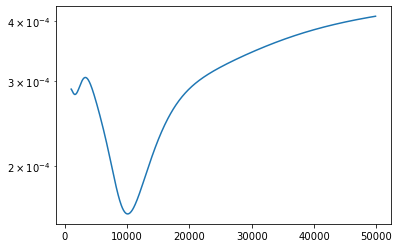

In [37]:
if spherical_ave=='weighted':
    Dsmooth = smooth_diff(Dinit, r[:-1])
    Dsmooth2 = smooth_diff_lowr(Dsmooth, r[:-1])
    print('Dinit shape: ', Dinit.shape)
    print('Dsmooth shape: ', Dsmooth.shape)
    print('Dsmooth2 shape', Dsmooth2.shape)

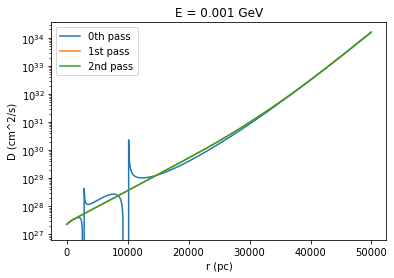

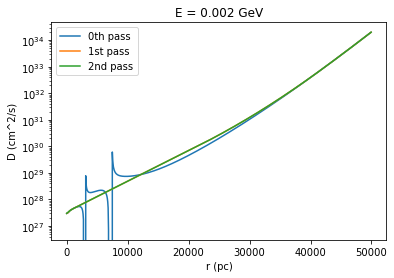

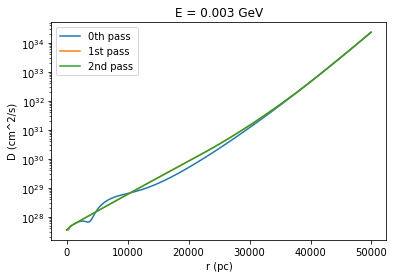

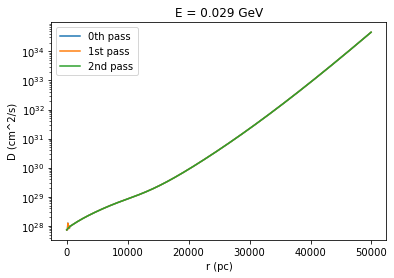

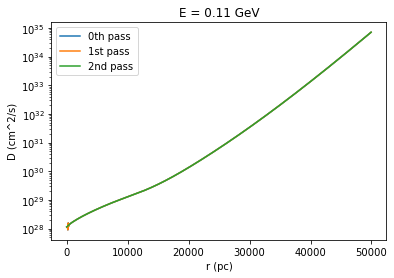

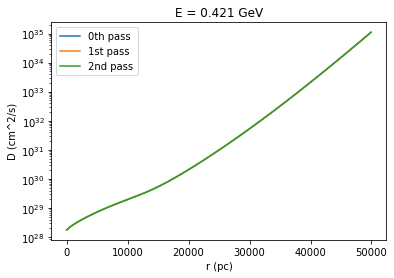

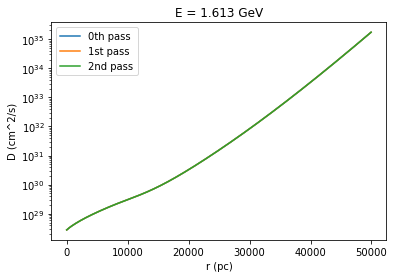

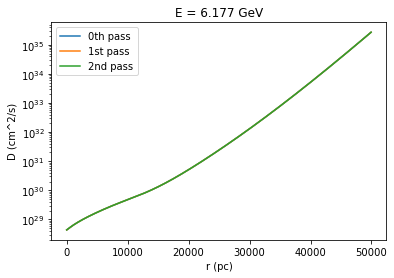

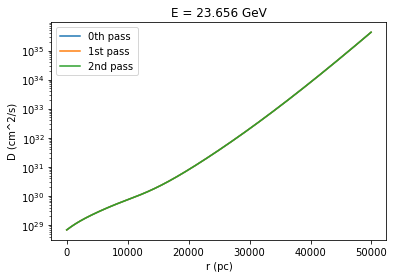

In [41]:
ind_set = [20, 50, 70, 150, 200, 250, 300, 350, 400]
for ind in ind_set:
    fig = plt.figure()
    plt.plot(r[:-1], Dinit[ind], label='0th pass')
    plt.plot(r[:-1], Dsmooth[ind], label='1st pass')
    plt.plot(r[:-1], Dsmooth2[ind], label='2nd pass')
    plt.yscale('log')
    plt.ylabel('D (cm^2/s)')
    plt.xlabel('r (pc)')
    plt.title('E = ' + str(np.round(E[ind], 3)) + ' GeV')
    plt.legend()